In [2]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [3]:
!echo $SPARK_HOME

/content/spark-3.5.0-bin-hadoop3


In [3]:
# !pip install py4j

In [4]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [13]:
# 1. Read in the AWS S3 bucket into a DataFrame.
from pyspark import SparkFiles
url = "https://2u-data-curriculum-team.s3.amazonaws.com/dataviz-classroom/v1.2/22-big-data/home_sales_revised.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("home_sales_revised.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+--------------------+----------+----------+------+--------+---------+-----------+--------+------+----------+----+
|                  id|      date|date_built| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|
+--------------------+----------+----------+------+--------+---------+-----------+--------+------+----------+----+
|f8a53099-ba1c-47d...|2022-04-08|      2016|936923|       4|        3|       3167|   11733|     2|         1|  76|
|7530a2d8-1ae3-451...|2021-06-13|      2013|379628|       2|        2|       2235|   14384|     1|         0|  23|
|43de979c-0bf0-4c9...|2019-04-12|      2014|417866|       2|        2|       2127|   10575|     2|         0|   0|
|b672c137-b88c-48b...|2019-10-16|      2016|239895|       2|        2|       1631|   11149|     2|         0|   0|
|e0726d4d-d595-407...|2022-01-08|      2017|424418|       3|        2|       2249|   13878|     2|         0|   4|
|5aa00529-0533-46b...|2019-01-30|      2017|218712|       2|        3|       196

In [34]:
# 2. Create a temporary view of the DataFrame.
df.createOrReplaceTempView('home_sales')

In [22]:
# 3. What is the average price for a four bedroom house sold in each year rounded to two decimal places?
query1 = """
SELECT date_built as YEAR, round(avg(price),2) as AVG_PRICE
FROM home_sales
WHERE bedrooms = 4
GROUP BY YEAR
ORDER BY YEAR DESC
"""
spark.sql(query1).show()

+----+---------+
|YEAR|AVG_PRICE|
+----+---------+
|2017|296576.69|
|2016|296050.24|
|2015|307908.86|
|2014|299073.89|
|2013|299999.39|
|2012|298233.42|
|2011| 302141.9|
|2010|296800.75|
+----+---------+



In [23]:
# 4. What is the average price of a home for each year the home was built that have 3 bedrooms and 3 bathrooms rounded to two decimal places?
query2 = """
SELECT date_built as YEAR, round(avg(price),2) as AVG_PRICE
FROM home_sales
WHERE bedrooms = 3 AND bathrooms = 3
GROUP BY YEAR
ORDER BY YEAR DESC
"""
spark.sql(query2).show()

+----+---------+
|YEAR|AVG_PRICE|
+----+---------+
|2017|292676.79|
|2016|290555.07|
|2015| 288770.3|
|2014|290852.27|
|2013|295962.27|
|2012|293683.19|
|2011|291117.47|
|2010|292859.62|
+----+---------+



In [24]:
# 5. What is the average price of a home for each year built that have 3 bedrooms, 3 bathrooms, with two floors,
# and are greater than or equal to 2,000 square feet rounded to two decimal places?
query3 = """
SELECT date_built as YEAR, round(avg(price),2) as AVG_PRICE
FROM home_sales
WHERE bedrooms = 3 AND bathrooms = 3 AND floors = 2 AND sqft_living >= 2000
GROUP BY YEAR
ORDER BY YEAR DESC
"""
spark.sql(query3).show()

+----+---------+
|YEAR|AVG_PRICE|
+----+---------+
|2017|280317.58|
|2016| 293965.1|
|2015|297609.97|
|2014|298264.72|
|2013|303676.79|
|2012|307539.97|
|2011|276553.81|
|2010|285010.22|
+----+---------+



In [28]:
# 6. What is the "view" rating for the average price of a home, rounded to two decimal places, where the homes are greater than
# or equal to $350,000? Although this is a small dataset, determine the run time for this query.

start_time = time.time()

query4 = """
SELECT view, round(avg(price),2) as AVG_PRICE
FROM home_sales
GROUP BY view
HAVING AVG_PRICE >= 350000
order by view desc
"""
# The tutor insisted that it's the avg price >= 350K and NOT regular price to be compared?
spark.sql(query4).show()

print("--- %s seconds ---" % (time.time() - start_time))


+----+----------+
|view| AVG_PRICE|
+----+----------+
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
|  80| 991767.38|
+----+----------+
only showing top 20 rows

--- 0.7805240154266357 seconds ---


In [31]:
# 7. Cache the the temporary table home_sales.
spark.sql('cache table home_sales')

DataFrame[]

In [32]:
# 8. Check if the table is cached.
spark.catalog.isCached('home_sales')

True

In [33]:
# 9. Using the cached data, run the query that filters out the view ratings with average price
#  greater than or equal to $350,000. Determine the runtime and compare it to uncached runtime.

start_time = time.time()

query5 = """
SELECT view, round(avg(price),2) as AVG_PRICE
FROM home_sales
GROUP BY view
HAVING AVG_PRICE >= 350000
order by view desc
"""
spark.sql(query5).show()

print("--- %s seconds ---" % (time.time() - start_time))


+----+----------+
|view| AVG_PRICE|
+----+----------+
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
|  80| 991767.38|
+----+----------+
only showing top 20 rows

--- 0.5107860565185547 seconds ---


In [35]:
# 10. Partition by the "date_built" field on the formatted parquet home sales data
partitioned_df = df.write.partitionBy("date_built").parquet("sample_data/home_sales_out_spark")


### Screenshot of partitioned data stored after partitioning code was run


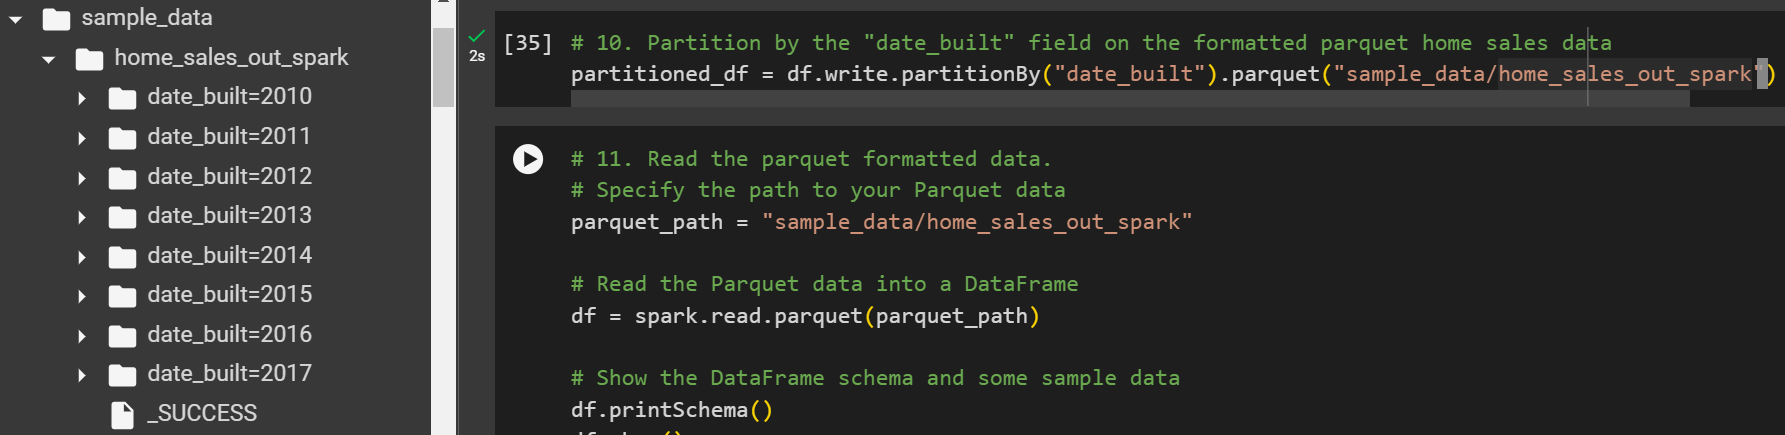

In [37]:
# 11. Read the parquet formatted data.
# Specify the path to your Parquet data
parquet_path = "sample_data/home_sales_out_spark"

# Read the Parquet data into a DataFrame
df_parquet_data = spark.read.parquet(parquet_path)

# Show the DataFrame schema and some sample data
df_parquet_data.printSchema()
df_parquet_data.show()


root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- bedrooms: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- sqft_living: string (nullable = true)
 |-- sqft_lot: string (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date_built: integer (nullable = true)

+--------------------+----------+------+--------+---------+-----------+--------+------+----------+----+----------+
|                  id|      date| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|date_built|
+--------------------+----------+------+--------+---------+-----------+--------+------+----------+----+----------+
|2ed8d509-7372-46d...|2021-08-06|258710|       3|        3|       1918|    9666|     1|         0|  25|      2015|
|941bad30-eb49-4a7...|2020-05-09|229896|       3|        3|       2197|    8641|     1|         0|   3| 

In [38]:
# 12. Create a temporary table for the parquet data.
table_name = "home_sales_parquet_data"
df.createOrReplaceTempView(table_name)

In [40]:
# 13. Run the query that filters out the view ratings with average price of greater than or equal to $350,000
# with the parquet DataFrame. Round your average to two decimal places.
# Determine the runtime and compare it to the cached version.

start_time = time.time()

query6 = """
SELECT view, round(avg(price),2) as AVG_PRICE
FROM home_sales_parquet_data
GROUP BY view
HAVING AVG_PRICE >= 350000
order by view desc
"""
# The tutor insisted that it's the avg price >= 350K and NOT regular price to be compared?
spark.sql(query6).show()


print("--- %s seconds ---" % (time.time() - start_time))

+----+----------+
|view| AVG_PRICE|
+----+----------+
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
|  80| 991767.38|
+----+----------+
only showing top 20 rows

--- 0.7385616302490234 seconds ---


Cached Runtime was: 0.5107860565185547 seconds

Runtime with Parquet data: 0.7385616302490234 seconds

Fetching data from cached memory was faster.

In [42]:
# 14. Uncache the home_sales temporary table.
spark.catalog.uncacheTable("home_sales_parquet_data")

In [43]:
# 15. Check if the home_sales is no longer cached
# Specifying the name of the temporary table
table_name_now_unchached = "home_sales_parquet_data"

# Check if the table is cached
is_cached = spark.catalog.isCached(table_name_now_unchached)

# Display the result
if is_cached:
    print(f"The table {table_name_now_unchached} is still cached.")
else:
    print(f"The table {table_name_now_unchached} is not cached.")


The table home_sales_parquet_data is not cached.
